# <center> </center>
# <center> **Deep Learning** </center>
# <center> **Sign Language Classifier**</center>

**Q** : Your friend Margot asked you for help. She works with deaf people and hence uses a lot of sign languge.

Margot has been hearing a lot about deep learning and the wonders it can do. She find tools such as speach-to-text especially fascinating. Her dream is that deaf people could use the sign language and everybody could read in normal letters what they say - a sign-to-text tool. :)

Part of the sign language are specific hand signs for indiviual letters of alphabet as shown for example here. This seems like a great start for her project.

Margot knows that without data, there is no deep learning. Luckily, she has got some old photos (stored in todo.pth) and she has started annotating these (todo_example.pth). It is, however, a lot of work and she hopes you could help her and use some clever neural network that could do its magic and annotate the data for her.

Margot also knows, that her example dataset is very small and therefore perhaps not too helpful. Luckily, she found another dataset with hand signs which is already annotated (old_annotated.pth). It looks somewhat funny but she hopes you will be able to use it.

Please, help Margot annotate the todo.pth dataset with the labels corresponding to the alphabet.

# Importing Necessary Modules

In [ ]:
# Sign Language Classification Project

## Import Required Libraries

import torch
import torch.nn as nn #NN modules
import torch.optim as optim # Optimizers for training
from torch.utils.data import DataLoader, TensorDataset #Data Loading -> handles batching and shuffling
import torch.nn.functional as F #Functional Operations -> Activation , loss

# Computer Vision libraries
import torchvision.transforms as transforms #Image preprocessing -> resizing, normalizing,data augmentation
import torchvision.models as models #Pre-trained Models -> ResNet
import cv2 #Image processing
from PIL import Image, ImageEnhance, ImageFilter #Python Imaging library for image operations

# Data Metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter #Count class distributions - checking for the data imbalance

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Data Loading

Data Loading Function

This code loads three types of data files for a machine learning project:

1.⁠ ⁠*Training data* (⁠ old_annotated.pth ⁠) - Data that has already been labeled/annotated

2.⁠ ⁠*Todo data* (⁠ todo.pth ⁠) - Data that still needs to be labeled

3.⁠ ⁠*Example data* (⁠ todo_example.pth ⁠) - Sample annotations to show how labeling should be done (optional)

The function loads all three files and prints the number of samples in each one.

In [ ]:
def load_datasets():

    try:
        # Loading annotated training data
        train_data = torch.load('old_annotated.pth', weights_only=False)
        print(f"Loaded training data: {len(train_data)} samples")

        # Loading data to be annotated
        todo_data = torch.load('todo.pth', weights_only=False)
        print(f"Loaded todo data: {len(todo_data)} samples")

        # Loading example annotations
        try:
            example_data = torch.load('todo_example.pth', weights_only=False)
            print(f"Loaded example data: {len(example_data)} samples")
            return train_data, todo_data, example_data
        except:
            print("No example data found, proceeding without it")
            return train_data, todo_data, None

    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Data Pre-Processing

1. We are enhancing the images from input(hand signs) by cleaning noise and improving visual quality.




*Steps :*

  •⁠ ⁠Removes noise while keeping edges sharp using OpenCV's bilateral filter

  •⁠ ⁠Makes the image more distinct by increasing contrast by 1.5 times

  •⁠ ⁠Enhances sharpness by 1.3 times to clarify details and shapes

  •⁠ ⁠Applies light blur to reduce processing artifacts


  **Bilateral Filter**

  The bilateral filter is used because for input:

  •⁠ ⁠Preserves sharp edges (hands and fingers as of here)

  •⁠ ⁠Maintains finger boundary definition while smoothing skin texture

  •⁠ ⁠Doesn't blur important gesture details


The combination of de-noising + contrast + sharpness enhancement is  used  as its  effective for sign data visulization.






In [ ]:
def pre_processor_filter_contrast_blur(image):

    # Converting to PIL Image if it's a tensor-> ensure consistent formatting for processing
    if isinstance(image, torch.Tensor):
        if image.dim() == 3 and image.shape[0] in [1, 3]:
            image = image.permute(1, 2, 0)
        image_np = image.numpy()
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        image_pil = Image.fromarray(image_np)
    else:
        image_pil = image

    # Apply denoising using OpenCV
    image_cv = np.array(image_pil)

    # Bilateral filter for noise reduction while preserving edges
    if len(image_cv.shape) == 3:
        denoised = cv2.bilateralFilter(image_cv, 9, 75, 75)
    else:
        denoised = cv2.bilateralFilter(image_cv, 9, 75, 75)

    # Convert back to PIL
    image_pil = Image.fromarray(denoised)

    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image_pil)
    image_pil = enhancer.enhance(1.5)

    # Enhance sharpness
    enhancer = ImageEnhance.Sharpness(image_pil)
    image_pil = enhancer.enhance(1.3)

    # Apply slight blur to reduce noise
    image_pil = image_pil.filter(ImageFilter.GaussianBlur(radius=0.5))

    return image_pil

2. We are Pre-Processing the image further with CLAHE and Morphological Operations

  *Steps:*

  •⁠  Convert the input image to Open CV format

  •⁠  Implement the Contrast Limited Adaptive Histogram Equalization(CLAHE)

  •⁠  ⁠Morphological Operations - Fills small holes using 2x2 kernel, connecting broken features

  •⁠  ⁠Removes small noise particles, still preserves the main image structure

  Why CLAHE?
  
  •⁠ CLAHE divides the image into small tiles and applies histogram equalization locally, which prevents over-amplification, while improving contrast in both dark and bright regions.
  
  Regular histogram equalization can over-enhance the images

In [ ]:
def pre_processor_clahe_morph(image):
    # Convert images by applying contrast enhancement
    if isinstance(image, torch.Tensor):
        if image.dim() == 3 and image.shape[0] in [1, 3]:
            image = image.permute(1, 2, 0)
        image_np = image.numpy()
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image

    # Handle different image formats
    if len(image_np.shape) == 3:
        if image_np.shape[2] == 3: #Checking if no of channels is 3(RGB) or diff
            image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)#Converting RGB to BGR, cause Cv2 works with BGR
        else:
            image_cv = image_np
    else:
        image_cv = image_np

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    if len(image_cv.shape) == 3:
        # Convert to LAB color space
        lab = cv2.cvtColor(image_cv, cv2.COLOR_BGR2LAB)#Converting BGR to LAB
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
        lab[:, :, 0] = clahe.apply(lab[:, :, 0]) #Apply CLAHE only to the Luminous channel
        image_cv = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
        image_cv = clahe.apply(image_cv)

    # Morphological operations(image cleaning techniques) to clean up the image
    kernel = np.ones((2, 2), np.uint8)#Here, we are creating a 2x2(to keep the details) kernel for subtle cleaning
    image_cv = cv2.morphologyEx(image_cv, cv2.MORPH_CLOSE, kernel)#fills small gaps and holes that helps to fill black spots
    image_cv = cv2.morphologyEx(image_cv, cv2.MORPH_OPEN, kernel)#removes small noise while maintaining the image structure

    # Converting back to PIL
    if len(image_cv.shape) == 3:
        image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    return Image.fromarray(image_cv)

# Data Visualization

We are doing Data Analysis for the Datasets, and checking the Labels, Number of Samples, Dimensions and plotting graphs for the Visualization

In [ ]:
def plot_label_distribution(label_counts, title="Label Distribution"):
    """Plot the distribution of labels as a bar chart."""
    labels, counts = zip(*sorted(label_counts.items()))
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=list(labels),
        y=list(counts),
        hue=list(labels),# Assign x variable to hue
        palette="Blues_d",
        legend=False# Hide redundant legend
    )
    plt.title(title)
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.show()

In [ ]:
# Data exploration and visualization
def exploration_data_visual(dataset, title="Dataset"):
    """Explore and visualize the dataset"""
    print(f"\n{title} Analysis:")
    print(f"Number of samples: {len(dataset)}")#Here, we are getting number of samples in the dataset

    # Extracting all labels from the dataset(both tensor and regular integer labels)
    labels = [dataset[i][1].item() if isinstance(dataset[i][1], torch.Tensor) else dataset[i][1] for i in
              range(len(dataset))]
    label_counts = Counter(labels)#To count the occurrences of each label

    print(f"Unique labels: {sorted(set(labels))}")#class and categories
    print(f"Label distribution: {dict(label_counts)}")#how many samples in each class

    plot_label_distribution(label_counts, title=f"{title} Label Distribution")
    # Getting the first image shape
    sample_img = dataset[0][0]
    print(f"Image shape: {sample_img.shape}")#Image dimension(CHW/HWC)

    return label_counts

In [ ]:
def plot_dataset(dataset, title="Dataset", max_samples=18):

    fig = plt.figure(figsize=(15, 10))
    columns = 6
    rows = 3

    plt.suptitle(title, fontsize=16)

    for i in range(min(columns * rows, len(dataset), max_samples)):
        img, label = dataset[i]

        plt.subplot(rows, columns, i + 1)
        plt.title(f"Label: {label.item() if isinstance(label, torch.Tensor) else label}")#handling both tensor labels and regular python labels

        # Handling different image formats
        if img.dim() == 3:
            if img.shape[0] in [1, 3]:  # CHW format
                img_np = img.permute(1, 2, 0).numpy()
            else:  # HWC format
                img_np = img.numpy()
        else:
            img_np = img.numpy()

        # Normalizing for display
        if img_np.max() > 1:
            img_np = img_np / 255.0

        plt.imshow(img_np.squeeze(), cmap='gray' if len(img_np.shape) == 2 else None)#2D image
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Dataset Class

 •⁠ Our SignLanguageDataset extends to torch.utils.data.Dataset class

 •⁠ In the Init method, it takes 3 params -> Dataset, Transformation Pipeline & Flag for Quality Enhancement

 •⁠ The Class calls the 2 image processing functions above

 •⁠ Returns the enhanced image with the corresponding label

In [ ]:
# Dataset Class
class SignLanguageDataset(torch.utils.data.Dataset): #Dataset class for Sign Language data


    def __init__(self, data, transform=None, enhance_quality=True):#init data, transforms and quality enhancement
        self.data = data#Store the data
        self.transform = transform#Store transform pipeline
        self.enhance_quality = enhance_quality#Flag to enable/disable

    def __len__(self):
        return len(self.data)#Return the total number of samples

    def __getitem__(self, idx):#Retreving a sample from dataset
        img, label = self.data[idx]

        # Ensure image is in correct format
        if img.dim() == 3 and img.shape[0] not in [1, 3]:
            img = img.permute(2, 0, 1)  # HWC to CHW


        #Calling the above functions(contrast, brightness----)
        img_enhanced = pre_processor_clahe_morph(img)
        img_enhanced = pre_processor_filter_contrast_blur(img_enhanced)

        #Transfroms is being done here (augmentation, normalization)
        if self.transform:
            img_enhanced = self.transform(img_enhanced)#PIL and tensors

        return img_enhanced, label#Return the image and label

# Image Transformations
 •⁠ Transformations are applied to img before feeding into a NN, for Data Augmentation(training only) and Standardization(training & validation)

 •⁠ train_transform is for the Training Data & val_transform is for Validation

 •⁠ We apply different transformation methods for the data like Resizing, Random Cropping with Scale, Color Jitter etc

 WHY Augmentation is not used for Validation?

  •⁠ If validation data is augmented, it becomes similar to training data, making it harder to detect if the model is memorizing rather than learning generalizable features.
  
  •⁠ Augmented validation data would introduce noise into this decision-making process


In [ ]:
def get_transforms():

    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),  #Resizing to larger size
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #scaling to ensure most of the sign(hands visible)
        transforms.RandomRotation(15),#rotation moderate by 15 degree to simulate hand sign
        transforms.RandomHorizontalFlip(0.05),  # Minimal flip for hand signs(as sign languages are not symmetric)
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1), #Randomly adjust color prop to simulate diff lightning conditions
        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),#geometric transformations like rotation , shifting and zooming for simulating diff camera angles
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3),#As its a hand sign and camera image no perpendicular alignment
        transforms.ToTensor(),#PIL to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),#Learned from ImageNet/prev experience
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))#Regularization technique to not rely on specific image regions(to prevent overfitting)
    ])
    #Test Set transforms without augmentation(Standardized Preprocessing)
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224), #Takes centre 224 pixels, no randomness
        transforms.ToTensor(),#PIL to Tensor([0,255] -> [0,1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#Always same normalization as training
    ])

    return train_transform, val_transform

# Sign - Language Classifier using ResNet18

 •⁠ This class is a CNN Model with ResNet18 as feature extractor without pre-trained weights.

 •⁠ ⁠*ResNet18 backbone* extracts hierarchical features from input images, while the custom classifier maps these features to sign language classes

 • ⁠*Custom classifier head* replaces the original ResNet18 classifier with a 5-layer deep network: ⁠ 512→256→128→64→25

 • *Multiple dropout layers* with progressive rates (0.5 → 0.3 → 0.3 → 0.25 → 0.25) prevent overfitting while maintaining information flow

 • We have implemented Parameter freezing, where only last 20 params remain trainable, allowing fine tuning of high level features, preserving low-lvl feature stability, reducing overfitting risk

 • Xavier initialization ensures proper weight initialization for new classifier layers, maintaining consistent variance across layers


 • Early layers remain frozen to preserve visual features like edges/textures

In [ ]:
# Sign Language Classifier
class SignLanguageClassifier(nn.Module):
    """CNN model with ResNet18 backbone we are using for sign lang classification

    We use the ResNet18 for extracting the features and add a custom classifier

    """

    def __init__(self, num_classes, dropout_rate=0.5):
        super(SignLanguageClassifier, self).__init__()

        # Init sign lang classifier
        # We take num_classes and dropout_rate as inputs
        self.backbone = models.resnet18(weights=None)

        # Freeze early layers for preserving low-level features
        #Only unfreeze the last 20 params
        #Allows fine tuning of higher level features while keeping low-level features stable
        for param in list(self.backbone.parameters())[:-20]:  # Unfreeze more layers
            param.requires_grad = False

        #Replace classifier with multi-layer head
        in_features = self.backbone.fc.in_features

        #Run classifier with multiple layers
        self.backbone.fc = nn.Sequential(

            nn.Dropout(dropout_rate), #Dropout layer
            nn.Linear(in_features, 512), #First fully connected layer
            nn.BatchNorm1d(512), #Batch normalization -> imrove convergence
            nn.ReLU(), #RELU activation

            nn.Dropout(dropout_rate * 0.6), #Second dropout with lower rate
            nn.Linear(512, 256), #Second fully layer : but reduce to 256 features
            nn.BatchNorm1d(256), #Second batch normalization layer
            nn.ReLU(), #RELU activation

            nn.Dropout(dropout_rate * 0.6), #Third dropout with lower rate
            nn.Linear(256, 128), #Third fully layer : but reduce to 128 features
            nn.BatchNorm1d(128), #Third batch normalization layer
            nn.ReLU(), #RELU activation

            nn.Dropout(dropout_rate * 0.5), #Fourth dropout with lower rate
            nn.Linear(128, 64), #Fourth fully layer : but reduce to 64 features
            nn.BatchNorm1d(64), #Fourth batch normalization layer
            nn.ReLU(), #RELU activation


            nn.Dropout(dropout_rate * 0.5), #Third Dropout
            nn.Linear(64, num_classes) #Final Output Layer
        )

        # Initialize weights of new classifier layers
        self._initialize_weights()

    def _initialize_weights(self):
        """

        Method for init weights to the classifier using Xavier initialization

        Helps in keeping variance of activations and gradients same(roughly) across layers
        :return:
        """
        for m in self.backbone.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x): #Forward pass through network
        return self.backbone(x)

# TRAINING THE MODEL

 •⁠ Here, we are training our Model. We start with applying Label Smoothing -> Cross Entropy Loss. We use 0.1 smoothing factor for removing overconfidence.

 • We use the AdamW Optimizer, which is a type of L2 Regularization. AdamW implements weight decay directly on the parameters, separate from gradient updates.

 • We use Learning Rate Scheduling to give diff learning rate to different parts of the model training[Cosine Annealing with Warm Restarts]. This method  adjusts the learning rate following a cosine curve. Warm restarts add a "restart" mechanism to cosine annealing. Instead of continuously decreasing the learning rate, it periodically "restarts" back to a higher value

 • We try to prevent exploding gradients by gradient clipping approach. Max norm = 1


 MODEL TRAINING

 Model Setup → Forward Pass → Loss Calculation → Backward Pass → Gradient Clipping → Parameter Update

 VALIDATION PHASE

 Model Setup → Gradient Disabled → Forward Pass Only → Metrics Calculation

 We calculate training loss, val loss, training accuracy, val accuracy

In [ ]:
#  Training function
def train_model(model, train_loader, val_loader, num_epochs=30,
                         learning_rate=0.001, patience=10):
    """Train the model with  techniques -> differential learning rate / label smoothing / gradient clipping and early stopping"""

    #Loss function with label smoothing to reduce overconfidence and to improve generalization

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Use different learning rates for different parts of the model / Crucial for transfer learning
    optimizer = optim.AdamW([
        {'params': model.backbone.fc.parameters(), 'lr': learning_rate}, #higher learning rate for new classifier head
        {'params': [p for n, p in model.backbone.named_parameters() if 'fc' not in n], 'lr': learning_rate * 0.1} #lower learning rate
    ], weight_decay=1e-4) #L2 regularization to prevent overfitting


    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    #init all variables
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    #For Each Epoch
    for epoch in range(num_epochs):
        # Training phase
        model.train() #Training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        #Iterating through training batches
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()#Zero grad from prev ieration
            outputs = model(images) #Compute model predictions
            loss = criterion(outputs, labels) #Compute loss btw pred and true labels
            loss.backward() #backward pass

            # Gradient clipping for avoiding exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()#update step

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()#Eval mode
        val_loss = 0.0#Init params
        val_correct = 0
        val_total = 0

        #Disable gradient computation for validation
        with torch.no_grad():
            for images, labels in val_loader: #Forward pass only
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate accuracy
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        scheduler.step()#updating the learning rate

        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Loading the best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, train_accuracies, val_accuracies




PLOTTING THE RESULTS
--------

In [ ]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting the  losses
    ax1.plot(train_losses, label='Train Loss', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plotting the accuracies
    ax2.plot(train_accuracies, label='Train Accuracy', linewidth=2)
    ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ALPHABET MAPPING

We are mapping each letter in the Alphabet to a Label from 0-25

In [ ]:
def create_alphabet_mapping(unique_labels):
    """Creating a function that maps from class indices to alphabet letters"""
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    sorted_labels = sorted(unique_labels)

    label_to_letter = {}#init
    letter_to_label = {}
#Create bidirectional mapping between dataset labels and Alpha letters
    for i, label in enumerate(sorted_labels):
        if i < len(alphabet):#Create mappings till alpha length
            letter = alphabet[i]
            label_to_letter[label] = letter#datatset label -> alpha letter
            letter_to_label[letter] = label#reverse mapping

    return label_to_letter, letter_to_label#return both mapping

# TEST TIME AUGMENTATION

• We use the below function for predicting the labels for the todo.pth Dataset.
Instead of just taking the image directly, we create multiple augmented versions of the same image. But why?

• The image we are considering are gestures, single predictions may be wrong, so by taking this method, we are creating 5 versions of this input image, and predicting the labels individually.

• We have implemented a voting mechanism here, which is based on the confidence score of each sample.

• Higher confidence label will be the final predicted label

In [ ]:
#Prediction with test-time augmentation
def tta_val(model, dataset, batch_size=32, tta_steps=5):
    """Predicting the labels with test-time augmentation" as its gesture data"""
    model.eval() # model ->  Model in evaluation mode

    # Creating multiple different augmentation transforms
    # That each transform will create a slightly different version of the same image

    tta_transforms = []
    for i in range(tta_steps):
        tta_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(224),
            transforms.RandomRotation(5),
            transforms.ToTensor(),#PIL to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        tta_transforms.append(tta_transform)

    all_predictions = []#List of prediction one per TTA
    all_confidences = []

    for tta_idx, tta_transform in enumerate(tta_transforms):
        print(f"TTA step {tta_idx + 1}/{tta_steps}")

        # Create dataset with current transformations
        tta_dataset = SignLanguageDataset(dataset.data, transform=tta_transform, enhance_quality=True)
        dataloader = DataLoader(tta_dataset, batch_size=batch_size, shuffle=False)#No shuffle as its a validation

        predictions = []
        confidences = []
    #Disable gradient computation as its forward ; for inference(prediction!!!)
        with torch.no_grad():
            for images, _ in dataloader:#Process image in batches
                images = images.to(device)
                outputs = model(images)#Forward pass through model
                probs = F.softmax(outputs, dim=1)
                max_probs, predicted = torch.max(probs, 1)# To get the highest probability class and value
            #Storing the prediction and confidences for this batch
                predictions.extend(predicted.cpu().numpy())
                confidences.extend(max_probs.cpu().numpy())
     #Store results from this TTA round
        all_predictions.append(predictions)#All predictions for this augmentation
        all_confidences.append(confidences)

    #Predictions and confidence using weighted voting
    final_predictions = []
    final_confidences = []
#Process each image's predictions across all TTA steps
    for i in range(len(all_predictions[0])):
        # Collect predictions for the particular sample(image) across all TTA steps
        sample_predictions = [pred[i] for pred in all_predictions]
        sample_confidences = [conf[i] for conf in all_confidences]

        # Use weighted voting(each prediction vote is weighted by its confidence)
        pred_counts = Counter()#Dict to accumulate weighted votes
        for pred, conf in zip(sample_predictions, sample_confidences):
            pred_counts[pred] += conf #Adding confidence as weight to this class prediction

        final_pred = pred_counts.most_common(1)[0][0]# Class with highest weight
        final_conf = pred_counts[final_pred] / len(sample_predictions)
     #Store Final results
        final_predictions.append(final_pred)
        final_confidences.append(final_conf)

    return final_predictions, final_confidences

Saving the MODEL predictions
------------------------------

In [ ]:
def save_predictions_csv(predictions, filename='predictions.csv'):
    """Save predictions to CSV file in the required format"""
    df = pd.DataFrame({
        'ID': range(len(predictions)),
        'Labels': predictions
    })
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

Main function to call all necessary functions and create the model
------------------------------------------------------------------

In [ ]:

"""Main function to execute the entire sign language classification"""
print("===  Margot's Sign Language Classifier ===\n")

# Loading the datasets
train_data, todo_data, example_data = load_datasets()

if train_data is None or todo_data is None:
    print("Error: Could not load required datasets")


# Combine training data with example data (todo_example.pth)
if example_data:
    print("Combining training data with example data...")
    combined_train_data = train_data + example_data
    print(f"Combined training data: {len(combined_train_data)} samples")
else:
    combined_train_data = train_data


===  Margot's Sign Language Classifier ===

Loaded training data: 27455 samples
Loaded todo data: 7029 samples
Loaded example data: 143 samples
Combining training data with example data...
Combined training data: 27598 samples


Dataset Preparation and Data Loader Configuration
------


Exploring datasets...

Combined Training Dataset Analysis:
Number of samples: 27598
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Label distribution: {3: 1202, 6: 1094, 2: 1155, 13: 1155, 16: 1283, 8: 1171, 22: 1230, 18: 1202, 10: 1120, 20: 1166, 17: 1297, 19: 1190, 21: 1092, 23: 1169, 24: 1121, 1: 1014, 12: 1060, 11: 1244, 15: 1098, 4: 968, 0: 1132, 5: 1209, 7: 1024, 14: 1202}


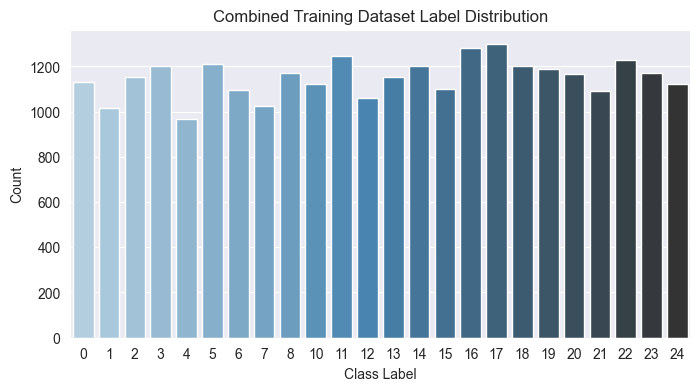

Image shape: torch.Size([3, 28, 28])


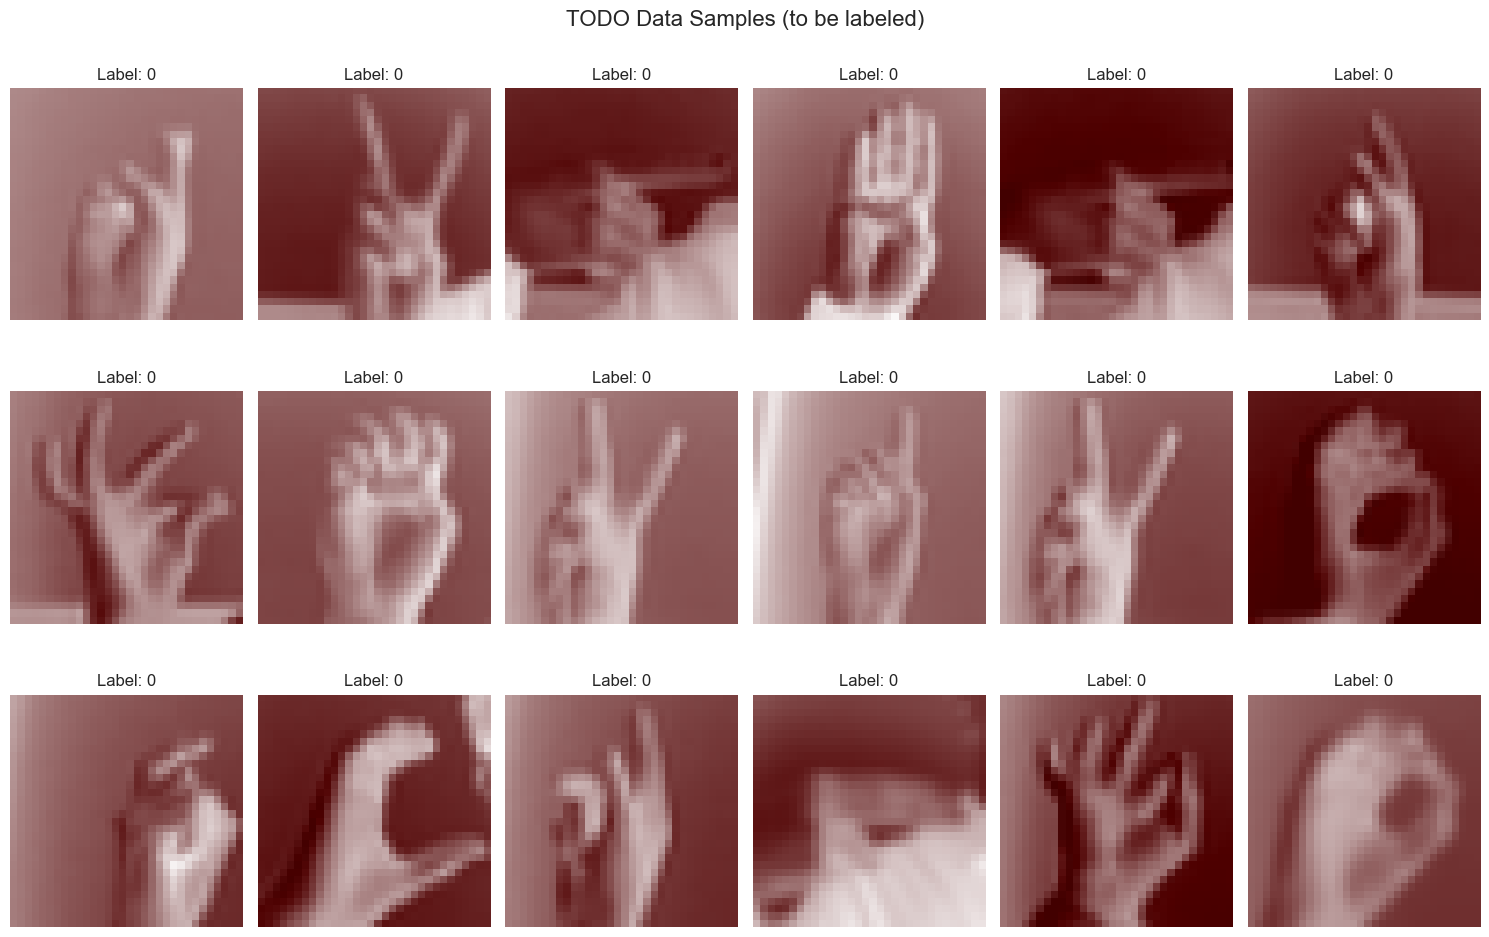


Unique labels: [3, 6, 2, 13, 16, 8, 22, 18, 10, 20, 17, 19, 21, 23, 24, 1, 12, 11, 15, 4, 0, 5, 7, 14]
Max label: 24
Number of classes: 25
Label to Letter mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X'}

Training samples: 23458
Validation samples: 4140
TODO samples to predict: 7029


In [ ]:
# Analyzing the combined training datasets for data distribution
print("\nExploring datasets...")
train_labels = exploration_data_visual(combined_train_data, "Combined Training Dataset")
plot_label_distribution
if todo_data:#Visulaize samples
    plot_dataset(todo_data, "TODO Data Samples (to be labeled)")

#Extracting the unique labels and num_classes
unique_labels = list(train_labels.keys())
max_label = max(unique_labels)
num_classes = max_label + 1#labels starting from 0 so +1
print(f"\nUnique labels: {unique_labels}")
print(f"Max label: {max_label}")
print(f"Number of classes: {num_classes}")
# Here we are creating a  bidirectional mapping num labels to  alphabet letters
label_to_letter, letter_to_label = create_alphabet_mapping(unique_labels)
print(f"Label to Letter mapping: {label_to_letter}")

# Get transforms for training and validation
train_transform, val_transform = get_transforms()

#Creating the datasets with transforms
train_dataset = SignLanguageDataset(combined_train_data, transform=train_transform, enhance_quality=True)
todo_dataset = SignLanguageDataset(todo_data, transform=val_transform, enhance_quality=True)

# Splitting the  training data for validation
train_size = int(0.85 * len(train_dataset))  # Using more data for training to prevent overfitting and maximize learning
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility of the same split every run
)

# Creating data loaders
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True,
                          num_workers=0, pin_memory=False) #Shuffling for better training
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False,
                        num_workers=0, pin_memory=False)#No shuffle as validation should be consistent

print(f"\nTraining samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"TODO samples to predict: {len(todo_dataset)}")

RESNET18 MODEL
----


Model initialized with 25 classes
Total parameters: 11,615,193
Trainable parameters: 9,422,745

Starting training...
Epoch [1/35]
Train Loss: 2.8319, Train Acc: 11.66%
Val Loss: 2.5966, Val Acc: 14.88%
LR: 0.000976
------------------------------------------------------------
Epoch [2/35]
Train Loss: 2.6117, Train Acc: 17.60%
Val Loss: 2.4415, Val Acc: 23.19%
LR: 0.000905
------------------------------------------------------------
Epoch [3/35]
Train Loss: 2.4827, Train Acc: 22.97%
Val Loss: 2.2791, Val Acc: 29.40%
LR: 0.000794
------------------------------------------------------------
Epoch [4/35]
Train Loss: 2.3558, Train Acc: 28.40%
Val Loss: 2.0966, Val Acc: 39.11%
LR: 0.000655
------------------------------------------------------------
Epoch [5/35]
Train Loss: 2.2053, Train Acc: 35.93%
Val Loss: 1.9325, Val Acc: 45.92%
LR: 0.000500
------------------------------------------------------------
Epoch [6/35]
Train Loss: 2.0845, Train Acc: 40.86%
Val Loss: 1.8329, Val Acc: 50.46%
LR

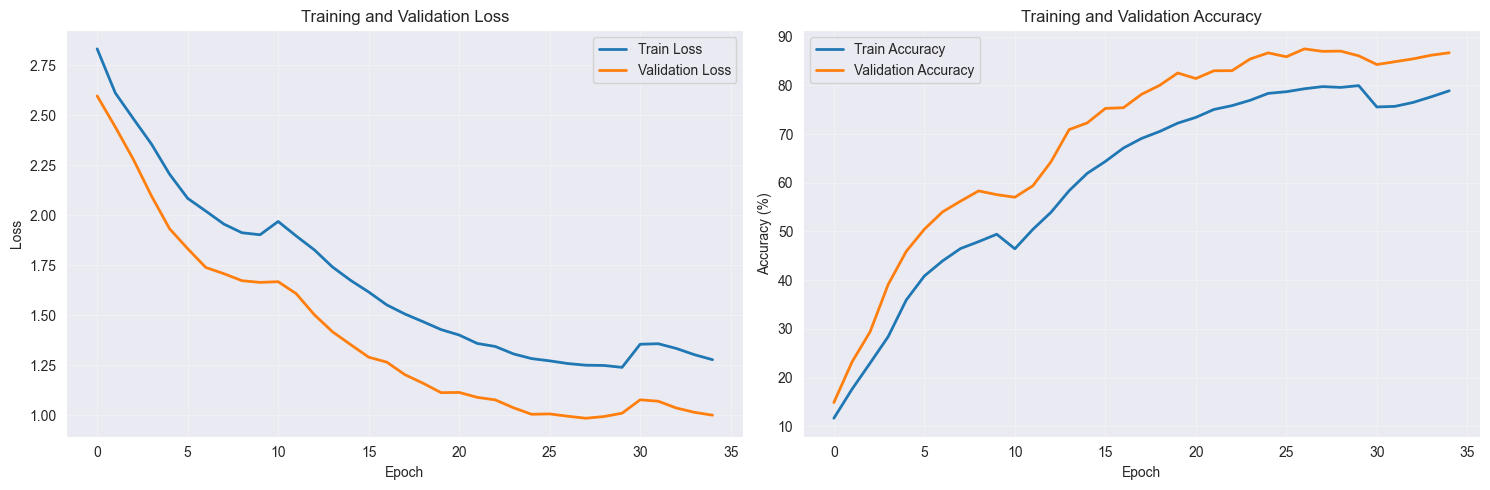


Making predictions with test-time augmentation...
TTA step 1/3
TTA step 2/3
TTA step 3/3

Prediction Summary:
Total predictions: 7029
Predicted letter distribution: {'L': 931, 'F': 310, 'A': 504, 'N': 689, 'R': 882, 'E': 153, 'V': 110, 'T': 595, 'U': 436, 'C': 262, 'I': 118, 'W': 31, 'O': 738, 'D': 366, 'G': 364, 'X': 28, 'B': 87, 'P': 209, 'Q': 102, 'J': 93, 'K': 5, 'H': 16}

Sample predictions (first 15):
Image 0: Predicted 'L' (confidence: 0.190)
Image 1: Predicted 'F' (confidence: 0.652)
Image 2: Predicted 'A' (confidence: 0.068)
Image 3: Predicted 'N' (confidence: 0.215)
Image 4: Predicted 'A' (confidence: 0.272)
Image 5: Predicted 'R' (confidence: 0.125)
Image 6: Predicted 'F' (confidence: 0.144)
Image 7: Predicted 'E' (confidence: 0.166)
Image 8: Predicted 'V' (confidence: 0.396)
Image 9: Predicted 'T' (confidence: 0.709)
Image 10: Predicted 'V' (confidence: 0.483)
Image 11: Predicted 'N' (confidence: 0.646)
Image 12: Predicted 'U' (confidence: 0.113)
Image 13: Predicted 'C' (c

In [ ]:
# Init the  model
model = SignLanguageClassifier(num_classes, dropout_rate=0.5).to(device)
print(f"\nModel initialized with {num_classes} classes")

# Counting and Displaying the  parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Training the  mode
print("\nStarting training...")
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, num_epochs=35, learning_rate=0.001, patience=15
)


plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Make predictions on data using test-time augmentation to get multiple augmented versions of the same image
#Reduce errors and capture gesture correctly
print("\nMaking predictions with test-time augmentation...")
predictions, confidences = tta_val(trained_model, todo_dataset, batch_size=16, tta_steps=3)

# Converting predictions to letters
predicted_letters = [label_to_letter.get(pred, f"Class_{pred}") for pred in predictions]


print(f"\nPrediction Summary:")
print(f"Total predictions: {len(predictions)}")
#Distribution of predicted letters
prediction_counts = Counter(predicted_letters)
print(f"Predicted letter distribution: {dict(prediction_counts)}")

#Confidence scores
print(f"\nSample predictions (first 15):")
for i in range(min(15, len(predictions))):
    letter = predicted_letters[i]
    conf = confidences[i]
    print(f"Image {i}: Predicted '{letter}' (confidence: {conf:.3f})")

#Saving Predictions
save_predictions_csv(predictions, 'predictions.csv')

# Saving the model
torch.save(trained_model.state_dict(), 'sign_language_model.pth')

# Creating and saving the annotated dataset
annotated_todo = []
for i, (img, _) in enumerate(todo_data):
    annotated_todo.append((img, predictions[i]))

torch.save(annotated_todo, 'todo_annotated.pth')
print("Annotated TODO dataset saved as 'todo_annotated.pth'")


print("\n=== Task Complete! ===")
print("Margot's TODO dataset has been successfully annotated !")
print("Generated files:")
print("- predictions.csv: Required submission format (ID, Labels)")
print(f"\nFinal validation accuracy: {max(val_accs):.2f}%")